<a href="https://colab.research.google.com/github/shailesh008/FacialKeypointRecognition/blob/master/FacialKeyPoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2                     # OpenCV library for computer vision
from PIL import Image
import time
import pandas as pd
import os

In [16]:
from google.colab import files

uploaded = files.upload()

Saving test.csv to test (1).csv
Saving training.csv to training.csv


In [11]:
#TRAIN_DIR = np.load('training.csv')
#TEST_DIR = np.load('test.csv')
TRAIN_DIR = os.getcwd()
print(TRAIN_DIR)
print(os.listdir(TRAIN_DIR))
df = pd.read_csv("test (1).csv")
print(df)

/content
['.config', 'sample_data']


FileNotFoundError: ignored

In [0]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from keras.models import load_model
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

def load_data(test=False):
    """
    Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Important that the files are in a `data` directory
    """  
    #FTRAIN = TRAIN_DIR
    #FTEST = TEST_DIR
    #fname = FTEST if test else FTRAIN
    if(test=='true'):
      df = pd.read_csv("test (1).csv")
    else:
      df = pd.read_csv("training.csv")  # load dataframes pd.read_csv("filename.csv") 

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)
    X = X.reshape(-1, 96, 96, 1) # return each images as 96 x 96 x 1

    if not test:  # only FTRAIN has target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

def plot_data(img, landmarks, axis):
    """
    Plot image (img), along with normalized facial keypoints (landmarks)
    """
    axis.imshow(np.squeeze(img), cmap='gray') # plot the image
    landmarks = landmarks * 48 + 48 # undo the normalization
    # Plot the keypoints
    axis.scatter(landmarks[0::2], 
        landmarks[1::2], 
        marker='o', 
        c='c', 
        s=40)

def plot_keypoints(img_path, 
                  face_cascade=cv2.CascadeClassifier('haarcascade_frontalface_alt.xml'),
                  model_path='my_model.h5'):
    # TODO: write a function that plots keypoints on arbitrary image containing human
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
    ax.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))

    if len(faces) == 0:
        plt.title('no faces detected')
    elif len(faces) > 1:
        plt.title('too many faces detected')
        for (x,y,w,h) in faces:
            rectangle = cv2.rectangle(img,(x,y),(x+w,y+h),(255,255,0),2)
            ax.imshow(cv2.cvtColor(rectangle, cv2.COLOR_BGR2RGB))
    elif len(faces) == 1:
        plt.title('one face detected')
        x,y,w,h = faces[0]
        bgr_crop = img[y:y+h, x:x+w] 
        orig_shape_crop = bgr_crop.shape
        gray_crop = cv2.cvtColor(bgr_crop, cv2.COLOR_BGR2GRAY)
        resize_gray_crop = cv2.resize(gray_crop, (96, 96)) / 255.
        model = load_model(model_path)
        landmarks = np.squeeze(model.predict(
            np.expand_dims(np.expand_dims(resize_gray_crop, axis=-1), axis=0)))
        ax.scatter(((landmarks[0::2] * 48 + 48)*orig_shape_crop[0]/96)+x, 
                   ((landmarks[1::2] * 48 + 48)*orig_shape_crop[1]/96)+y, 
                   marker='o', c='c', s=40)
    plt.show()

In [28]:
#from utils import *

# Load training set
X_train, y_train = load_data()
print("X_train.shape == {}".format(X_train.shape))
print("y_train.shape == {}; y_train.min == {:.3f}; y_train.max == {:.3f}".format(
    y_train.shape, y_train.min(), y_train.max()))

# Load testing set
X_test, _ = load_data(test=True)
print("X_test.shape == {}".format(X_test.shape))

X_train.shape == (2140, 96, 96, 1)
y_train.shape == (2140, 30); y_train.min == -0.920; y_train.max == 0.996
X_test.shape == (2140, 96, 96, 1)


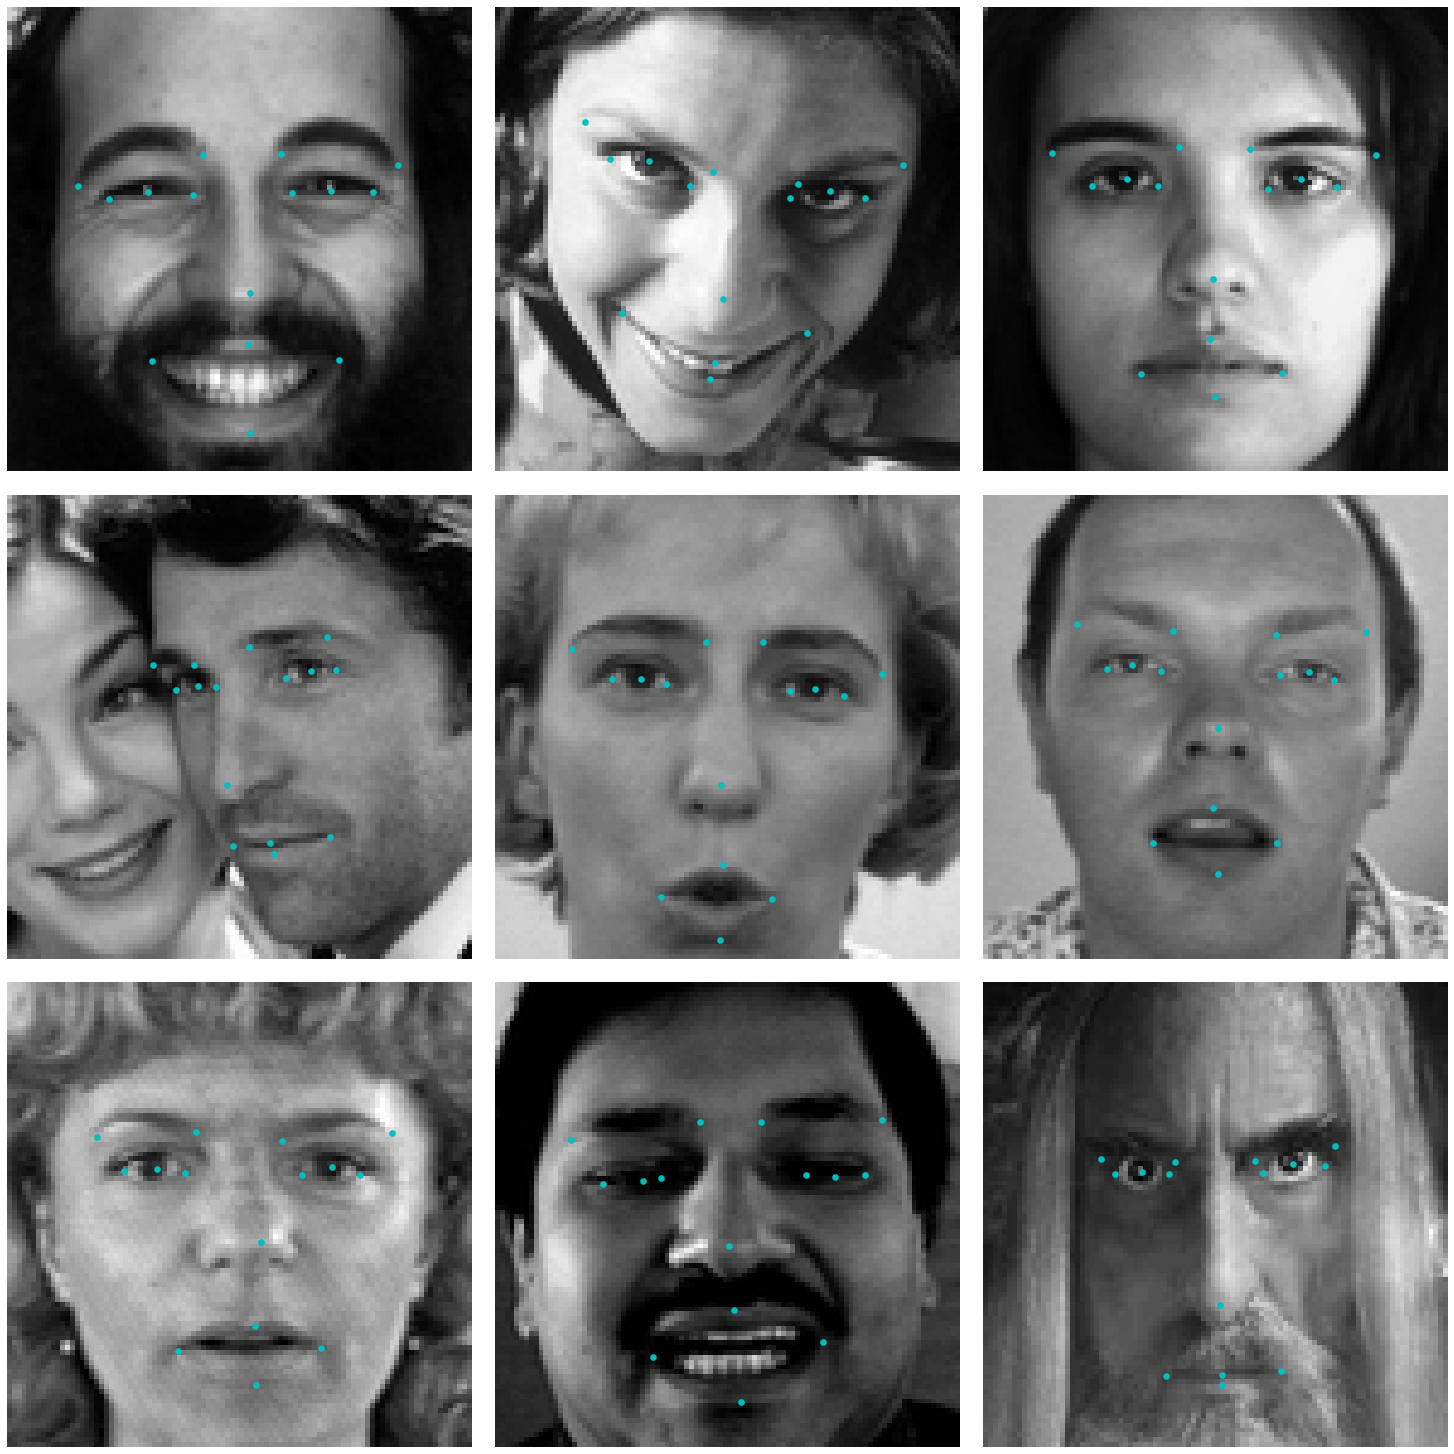

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    plot_data(X_train[i], y_train[i], ax)

In [30]:
# Import deep learning resources from Keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.layers import Flatten, Dense


## TODO: Specify a CNN architecture
# Your model should accept 96x96 pixel graysale images in
# It should have a fully-connected output layer with 30 values (2 for each facial keypoint)

model = Sequential()

# Define your architecture.
model.add(Conv2D(filters=32, kernel_size=3, activation='relu', 
                        input_shape=(96, 96, 1)))

model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(212, activation='relu'))
model.add(Dense(30))

# Summarize the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         147584    
__________

In [33]:
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.callbacks import ModelCheckpoint 

## TODO: Compile the model
model.compile(Adamax(), loss='mean_squared_error', metrics=['accuracy'])

# Save the model weights
checkpointer = ModelCheckpoint(filepath=TRAIN_DIR+'/weights_facial_keypoints.h5', 
                               verbose=1, save_best_only=True)

## TODO: Train the model
history = model.fit(X_train, y_train, 
          validation_split=0.2,
          epochs=50, batch_size=20, callbacks=[checkpointer], verbose=1)

## TODO: Save the model as model.h5
model.save('my_model.h5')

Train on 1712 samples, validate on 428 samples
Epoch 1/50
1712/1712 [==============================] - 39s 23ms/step - loss: 0.0066 - acc: 0.6770 - val_loss: 0.0045 - val_acc: 0.6963

Epoch 00001: val_loss improved from inf to 0.00454, saving model to /content/weights_facial_keypoints.h5
Epoch 2/50
1712/1712 [==============================] - 38s 22ms/step - loss: 0.0049 - acc: 0.7044 - val_loss: 0.0044 - val_acc: 0.6963

Epoch 00002: val_loss improved from 0.00454 to 0.00435, saving model to /content/weights_facial_keypoints.h5
Epoch 3/50
1712/1712 [==============================] - 38s 22ms/step - loss: 0.0049 - acc: 0.7062 - val_loss: 0.0045 - val_acc: 0.6963

Epoch 00003: val_loss did not improve from 0.00435
Epoch 4/50
1712/1712 [==============================] - 38s 22ms/step - loss: 0.0047 - acc: 0.7074 - val_loss: 0.0043 - val_acc: 0.6963

Epoch 00004: val_loss improved from 0.00435 to 0.00430, saving model to /content/weights_facial_keypoints.h5
Epoch 5/50
1712/1712 [=========

In [3]:
## TODO: Visualize the training and validation loss of your neural network
model.load_weights(TRAIN_DIR+'/my_model.h5')

# Plotting
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

NameError: ignored

In [0]:
y_test = model.predict(X_test)
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    plot_data(X_test[i], y_test[i], ax)

In [0]:
# Load in color image for face detection
image = cv2.imread('images/obamas4.jpg')

# Convert the image to RGB colorspace
image_copy = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize = (9,9))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('image copy')
ax1.imshow(image_copy)

In [0]:
### TODO: Use the face detection code we saw in Section 1 with your trained conv-net 
## TODO : Paint the predicted keypoints on the test image
# Extract the pre-trained face detector from an xml file
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# Convert the RGB  image to grayscale
gray = cv2.cvtColor(image_copy, cv2.COLOR_RGB2GRAY)

# Detect the faces in image
faces = face_cascade.detectMultiScale(gray, 1.25, 6)

# Make a copy of the orginal image to draw face detections on
image_with_detections = np.copy(image_copy)

for(x,y,w,h) in faces:
     # Add a red bounding box to the detections image
    cv2.rectangle(image_with_detections, (x,y), (x+w,y+h), (255,0,0), 3)

# plot our image
fig = plt.figure(figsize = (9,9))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('image_with_detections')
ax1.imshow(image_with_detections)

In [0]:
cropped_faces = []
for(x,y,w,h) in faces:
    # crop the section where the face is located
    face = gray[y:y+h,x:x+w]
    # resize and normalize
    face = cv2.resize(face, (96, 96)) / 255
    # Need to expand because CNN expects conv2d_1_input to have 4 dimensions
    face = np.expand_dims(face, axis=2)
    cropped_faces.append(face)

# load model
model = load_model('./my_model.h5')
X_faces = np.asarray(cropped_faces)
y_faces = model.predict(X_faces)

fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(len(faces)):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    plot_data(X_faces[i], y_faces[i], ax)

In [0]:
# Plot the Facial Keypoints on the Original image

# plot the image
fig = plt.figure(figsize = (9,9))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Original Image')

for i in range(len(faces)):
    x, y, w, h = faces[i]
    # rescaling back to original color image
    x_keypoints = y_faces[i][0::2] * 48 + 48
    x_scaled = (x_keypoints * w / 96) + x
    y_keypoints = y_faces[i][1::2] * 48 + 48
    y_scaled = (y_keypoints * h / 96) + y

    ax1.scatter(x_scaled, y_scaled, marker='.', c='b', s=20)

ax1.imshow(image_copy)